# Dataset loading

Download dataset partitions.

In [3]:
!gdown https://drive.google.com/file/d/1aQ_mpyoxlQ2OgJ7vXkPk04sogAIpbyNF/view?usp=sharing --fuzzy
!gdown https://drive.google.com/file/d/1-1bTtmmSau_o4MHBqT_FizS0-x_TwH4z/view?usp=sharing --fuzzy
!gdown https://drive.google.com/file/d/1-4T8FSnJK0PZmOuwS295BTg68lA5Q49-/view?usp=sharing --fuzzy
!gdown https://drive.google.com/file/d/1-7gXamdIWTDISiyOu40bd0xCfg1Q4a-O/view?usp=sharing --fuzzy
!gdown https://drive.google.com/file/d/1-8A598Uqj2RV705DaFF5HdM2X12bowFx/view?usp=sharing --fuzzy

Downloading...
From: https://drive.google.com/uc?id=1aQ_mpyoxlQ2OgJ7vXkPk04sogAIpbyNF
To: /content/split_1.record
100% 554M/554M [00:01<00:00, 315MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-1bTtmmSau_o4MHBqT_FizS0-x_TwH4z
To: /content/split_2.record
100% 573M/573M [00:05<00:00, 97.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-4T8FSnJK0PZmOuwS295BTg68lA5Q49-
To: /content/split_3.record
100% 600M/600M [00:10<00:00, 59.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-7gXamdIWTDISiyOu40bd0xCfg1Q4a-O
To: /content/split_4.record
100% 570M/570M [00:08<00:00, 64.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-8A598Uqj2RV705DaFF5HdM2X12bowFx
To: /content/split_5.record
100% 639M/639M [00:12<00:00, 50.8MB/s]


Define loading paths.

In [4]:
tf_records_path = '/content/split_{}.record'

# Dataset decoding

Define a set of decoding functions.

In [5]:
import tensorflow as tf
import numpy as np

def load_tf_records(filepath):
    filenames = tf.io.gfile.glob(filepath)
    dataset = tf.data.TFRecordDataset(filenames,num_parallel_reads=tf.data.experimental.AUTOTUNE)
    return dataset

def tf_records_file_features_description():
    image_feature_description = {
        
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image': tf.io.FixedLenFeature([],tf.string),
        'label/P': tf.io.FixedLenFeature([], tf.float32),
        'label/K': tf.io.FixedLenFeature([], tf.float32),
        'label/Mg': tf.io.FixedLenFeature([], tf.float32),
        'label/Ph': tf.io.FixedLenFeature([], tf.float32),
    }
    return image_feature_description

def decode_dataset(example_proto):
    features=tf.io.parse_single_example(example_proto, tf_records_file_features_description())

    image=features['image']
    height=features['image/height']
    width=features['image/width']
    image=tf.io.decode_raw(image,tf.int16)
    image=tf.reshape(image,[height,width,150])

    P=features['label/P']
    K=features['label/K']
    Mg=features['label/Mg']
    Ph=features['label/Ph']

    height=features['image/height']
    width=features['image/width']

    label=[P,K,Mg,Ph]

    return image, label, height, width

# Dataset analysis
We will use the tf.data.datest API 

It is not required to run this section to train the model.

Load train and test datasets.

In [6]:
# Load dataset partitions

splits = [load_tf_records(tf_records_path.format(i)).map(decode_dataset, num_parallel_calls=tf.data.AUTOTUNE) for i in range(1,6)]

Concatenate dataset partitions for analysis purposes.

In [7]:
full_dataset = splits[0].concatenate(splits[1]).concatenate(splits[2]).concatenate(splits[3]).concatenate(splits[4])

Show dataset sizes.

In [8]:
#[len(list(partition)) for partition in splits] #High RAM usage
num_images = [346, 346, 346, 347, 347]
print('Number of images in each partition: ', num_images)
total_num_images = sum(num_images)
print('Total number of images: ', total_num_images)

Number of images in each partition:  [346, 346, 346, 347, 347]
Total number of images:  1732


Find maximum and minimum intensity values for both datasets.

In [9]:
# Find maximum reflectance

def find_max(dataset):                      
    max = 0
    for image, label, height, width in dataset:
        max_reflectance = np.amax(image)
        if max_reflectance > max:
            max = max_reflectance
    return(max)

# Find minimum reflectance

def find_min(dataset, min):
    for image, label, height, width in dataset:
        min_reflectance = np.amin(image)
        if min_reflectance < min:
            min = min_reflectance
    return(min)

In [10]:
max_reflectance_overall = find_max(full_dataset)
min_reflectance_overall = find_min(full_dataset, max_reflectance_overall)
print('Max reflectance overall:', max_reflectance_overall)
print('Min reflectance overall:', min_reflectance_overall)

Max reflectance overall: 5419
Min reflectance overall: -3


Find maximum height and width of images in both datasets.

In [11]:
shape_data = np.array(list(full_dataset.map(lambda image, label, height, width: tf.shape(image)[0:2]).as_numpy_iterator()))
h_dims, w_dims = np.hsplit(shape_data, 2)

max_height = np.amax(h_dims)
max_width = np.amax(w_dims)
print('Max height train:', max_height)
print('Max width train:', max_width)

Max height train: 268
Max width train: 284


Show image size distribution in a bar chart.

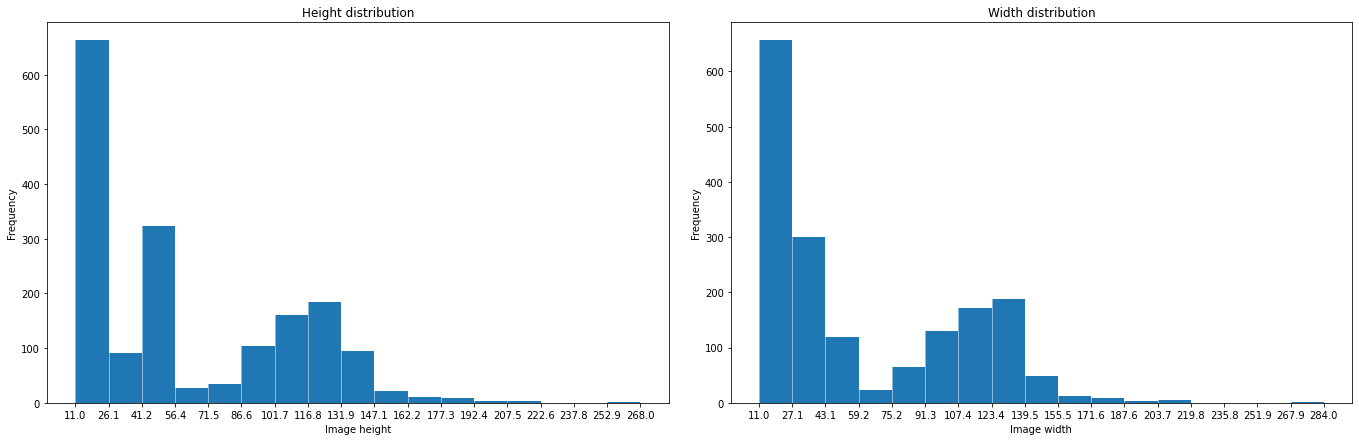

In [12]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(25,7))

plt.subplots_adjust(wspace=0.1, hspace=0.4, right=0.85)

n_h, bins_h, patches_h = axs[0].hist(h_dims, bins='auto')
axs[0].set_title('Height distribution')
axs[0].set_xlabel('Image height')
axs[0].set_ylabel('Frequency')
axs[0].set_xticks(bins_h)
axs[0].grid(color='white', lw = 0.5, axis='x')

n_w, bins_w, patches_w = axs[1].hist(w_dims, bins='auto')
axs[1].set_title('Width distribution')
axs[1].set_xlabel('Image width')
axs[1].set_ylabel('Frequency')
axs[1].set_xticks(bins_w)
axs[1].grid(color='white', lw = 0.5, axis='x')

plt.show()

Calculate the average, median and standard deviation for the ground truth values.

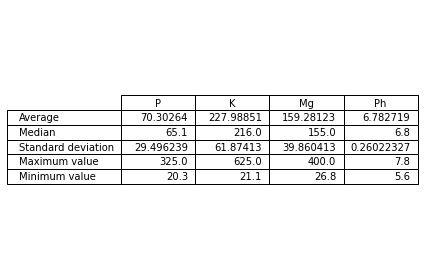

In [13]:
# Calculate average, median and standard deviation for ground truth values

import pandas as pd

gt_data = np.array(list((full_dataset.map(lambda image, label, height, width: label)).as_numpy_iterator()))

gt_avg = np.mean(gt_data, axis=0)
gt_median = np.median(gt_data, axis=0)
gt_std = np.std(gt_data, axis=0)
gt_max = np.amax(gt_data, axis=0)
gt_min = np.amin(gt_data, axis=0)
gt_stats = np.append([gt_avg], [gt_median, gt_std, gt_max,gt_min], axis=0)

fig, ax = plt.subplots()
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

df=pd.DataFrame(gt_stats, columns=['P', 'K', 'Mg', 'Ph'],)

ax.table(cellText=df.values, colLabels=df.columns, rowLabels=['Average', 'Median', 'Standard deviation', 'Maximum value','Minimum value'], loc='center')

fig.tight_layout()

plt.show()

Find baseline mse in order to later define evaluation metrics.

In [14]:
mse_baseline = np.mean((gt_data-gt_avg)**2, axis=0)
print(mse_baseline)

[8.7002814e+02 3.8284080e+03 1.5888525e+03 6.7716144e-02]


Print some entries.

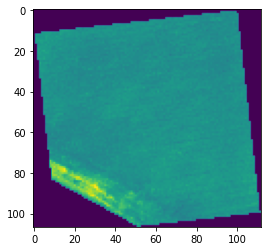

[ 85.5 234.  152.    6.9]


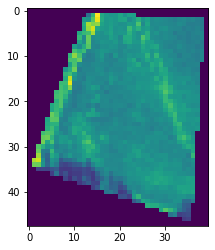

[ 76.6 351.  165.    6.9]


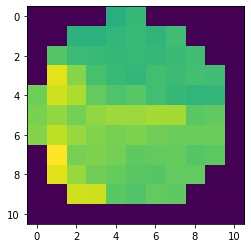

[123.  255.  175.    7.3]


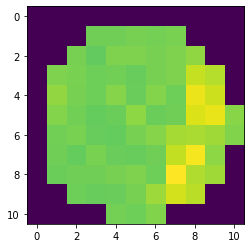

[ 65.4 283.  247.    6.8]


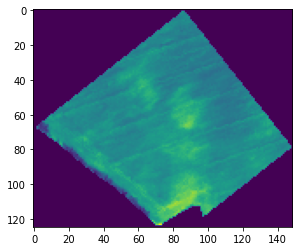

[ 75.  197.  157.    6.5]


In [15]:
for image, label, height, width in full_dataset.take(5):
  plt.imshow(image[:,:,1].numpy())
  plt.show()
  print(label.numpy())


# Dataset preprocessing

In [16]:
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import pandas as pd
import os
import random as rn
import numpy as np
import tensorflow as tf

rn.seed(2)
np.random.seed(3)
tf.random.set_seed(1)

AUTO = tf.data.AUTOTUNE 

Define preprocessing values.

In [18]:
max_reflectance_overall = 5419

max_height = 268
max_width = 284

total_num_images = 1732
num_images = [346, 346, 346, 347, 347]

max_gt_values = [325, 625, 400, 14]

mse_baseline = [8.7002814e+02, 3.8284080e+03, 1.5888525e+03, 6.7716144e-02]

!gdown https://drive.google.com/file/d/12NScF4TLmZXx2oo-hfEfbkqgi6IYMmiO/view?usp=sharing --fuzzy
std_vec = tf.cast(tf.reshape(np.load('/content/std_vector.npy'), [150]), dtype='float32')

Downloading...
From: https://drive.google.com/uc?id=12NScF4TLmZXx2oo-hfEfbkqgi6IYMmiO
To: /content/std_vector.npy
100% 1.33k/1.33k [00:00<00:00, 2.26MB/s]


Define normalization and augmentation functions for the train set.

In [20]:
target_image_size = 32

# Function to normalize the train dataset
def normalize_train(image,label, height, width, std_vec, max_gt_values):
    
    image = tf.cast(image,tf.float32)
    image = image/std_vec
    label /= max_gt_values

    return image, label, height, width

# Function that repeats a patch horizontally with random flips
def make_horizontal_patch_train(patch, nx):
    
    hor_patch = tf.image.random_flip_left_right(tf.image.random_flip_up_down(patch, seed=72), seed=64)
    i=0

    def cond(hor_patch, patch, i, nx):
        return tf.less(i, nx-1)
    def body(hor_patch, patch, i, nx):
        hor_patch = tf.concat([hor_patch, tf.image.random_flip_left_right(tf.image.random_flip_up_down(patch, seed=49), seed=95)], 1)
        i+=1
        return hor_patch, patch, i, nx

    hor_patch, _, _, _ = tf.while_loop(cond, body, [hor_patch, patch, i, nx])

    return hor_patch

# Function that repeats small images applying random flips to create a bigger image
def image_repetition_train(image, height, width):
    
    nx = tf.math.floordiv(target_image_size, tf.cast(width, tf.int32))
    ny = tf.math.floordiv(target_image_size, tf.cast(height, tf.int32))
    patch = image
    image = make_horizontal_patch_train(patch, nx)
    i=0

    def cond(image, patch, i, ny):
        return tf.less(i, ny-1)
    def body(image, patch, i, ny):
        image = tf.concat([image, make_horizontal_patch_train(patch, nx)], 0)
        i+=1
        return image, patch, i, ny
    
    image, _, _, _= tf.while_loop(cond, body, [image, patch, i, ny])

    image = tf.cond(tf.math.maximum(nx, ny)==1, lambda: tf.image.resize(image, [target_image_size, target_image_size], method='bilinear', antialias=False), lambda: tf.image.pad_to_bounding_box(image, 0, 0, target_image_size, target_image_size))

    return image

# Function to resize images to [target_image_size, target_image_size, 150]
def pad_with_patches_train(image, label, height, width):
    
    max_dim = tf.math.maximum(height, width)
    image = tf.cond(max_dim<target_image_size, lambda: image_repetition_train(image, height, width), lambda: tf.image.resize(image, [target_image_size, target_image_size], method='bilinear', antialias=False))
    image = add_gauss_noise(image)

    index=tf.random.uniform(shape=[],maxval=4,dtype=tf.dtypes.int32,seed=32)
    
    image=tf.cond(tf.equal(index,1),lambda: tf.image.flip_left_right(image), lambda: image)

    image=tf.cond(tf.equal(index,2),lambda: tf.image.flip_up_down(image), lambda: image)

    image=tf.cond(tf.equal(index,3),lambda: tf.image.flip_left_right(tf.image.flip_up_down(image)), lambda: image)

    return image, label

# Function to add gaussian noise
def add_gauss_noise(image):
  
    mean = 0
    std = 0.05
      
    gauss = tf.random.normal([target_image_size, target_image_size, 150], mean, std, seed=910)

    noisy = image + gauss

    return noisy

Training setup.

In [21]:
# Any number in [1,5]
test_partition_id = 5
num_train_images = total_num_images - num_images[test_partition_id-1]

epochs = 400
batch_size = 32
steps_per_epoch = num_train_images//batch_size

Dataset mapping (tf.data.Dataset API).

In [22]:
# Concatenate partitions to form the train set, the partition chosen as the test partition is excluded
splits = [load_tf_records(tf_records_path.format(i)).map(decode_dataset, num_parallel_calls=tf.data.AUTOTUNE) for i in range(1,6)]
index = list(range(5))
index.pop(test_partition_id-1)

ds = splits[index[0]]
index.pop(0)

for i in index:
    ds = ds.concatenate(splits[i])

# Normalize, cache, shuffle, pad, batch and prefetch train dataset
train_data = ds.take(1376)
train_data = train_data.map(lambda image, label, height, width: normalize_train(image, label, height, width, std_vec, max_gt_values), num_parallel_calls=AUTO).cache()
train_data = train_data.shuffle(num_train_images, seed=1866)
train_data = train_data.map(lambda image, label, height, width: pad_with_patches_train(image, label, height, width), num_parallel_calls=AUTO)
train_data = train_data.batch(batch_size=batch_size, drop_remainder=True)
train_data = train_data.prefetch(AUTO)

# Normalize, cache, shuffle, pad, batch and prefetch validation dataset
val_data = ds.skip(1376)
val_data = val_data.map(lambda image, label, height, width: normalize_train(image, label, height, width, std_vec, max_gt_values), num_parallel_calls=AUTO).cache()
val_data = val_data.map(lambda image, label, height, width: pad_with_patches_train(image, label, height, width), num_parallel_calls=AUTO)
val_data = val_data.batch(batch_size=10, drop_remainder=False)
val_data = val_data.prefetch(AUTO)

Print some training images.

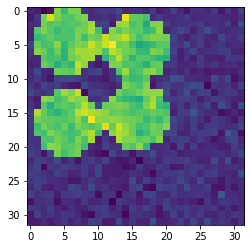

[0.168  0.3424 0.595  0.5   ]


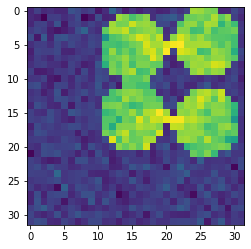

[0.20584616 0.2816     0.2875     0.5214286 ]


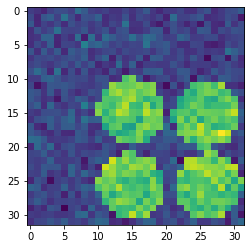

[0.41230768 0.3648     0.4775     0.4642857 ]


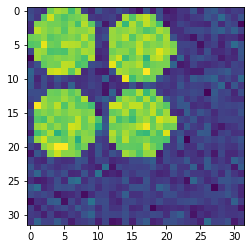

[0.168     0.304     0.325     0.5142857]


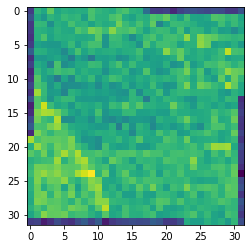

[0.10184615 0.2624     0.455      0.45000002]


In [23]:
for image, label in train_data.unbatch().take(5):
        plt.imshow(image[:,:,0])
        plt.show()
        print(label.numpy())  

# Build and train NN model
EfficientNet-Lite: the following cell is adapted from https://github.com/sebastian-sz/efficientnet-lite-keras, distributed under Apache License 2.0. We defined a new "EfficientNetLiteB0mod" setting width and depth to 0.5.

In [24]:
import copy
import math

import tensorflow as tf
from tensorflow.keras import layers

if tf.__version__ < "2.8":  # Keras has been moved to separate repository
    from tensorflow.python.keras.applications import imagenet_utils
else:
    from keras.applications import imagenet_utils

from tensorflow.python.keras import backend
from tensorflow.python.keras.utils import layer_utils
from tensorflow.python.lib.io import file_io

DEFAULT_BLOCKS_ARGS = [
    {
        "kernel_size": 3,
        "repeats": 1,
        "filters_in": 32,
        "filters_out": 16,
        "expand_ratio": 1,
        "id_skip": True,
        "strides": 1,
    },
    {
        "kernel_size": 3,
        "repeats": 2,
        "filters_in": 16,
        "filters_out": 24,
        "expand_ratio": 6,
        "id_skip": True,
        "strides": 2,
    },
    {
        "kernel_size": 5,
        "repeats": 2,
        "filters_in": 24,
        "filters_out": 40,
        "expand_ratio": 6,
        "id_skip": True,
        "strides": 2,
    },
    {
        "kernel_size": 3,
        "repeats": 3,
        "filters_in": 40,
        "filters_out": 80,
        "expand_ratio": 6,
        "id_skip": True,
        "strides": 2,
    },
    {
        "kernel_size": 5,
        "repeats": 3,
        "filters_in": 80,
        "filters_out": 112,
        "expand_ratio": 6,
        "id_skip": True,
        "strides": 1,
    },
    {
        "kernel_size": 5,
        "repeats": 4,
        "filters_in": 112,
        "filters_out": 192,
        "expand_ratio": 6,
        "id_skip": True,
        "strides": 2,
    },
    {
        "kernel_size": 3,
        "repeats": 1,
        "filters_in": 192,
        "filters_out": 320,
        "expand_ratio": 6,
        "id_skip": True,
        "strides": 1,
    },
]

CONV_KERNEL_INITIALIZER = {
    "class_name": "VarianceScaling",
    "config": {"scale": 2.0, "mode": "fan_out", "distribution": "truncated_normal"},
}

DENSE_KERNEL_INITIALIZER = {
    "class_name": "VarianceScaling",
    "config": {"scale": 1.0 / 3.0, "mode": "fan_out", "distribution": "uniform"},
}

WEIGHTS_BASE_URL = (
    "https://github.com/sebastian-sz/efficientnet-lite-keras/releases/download/v1.0/"
)
WEIGHTS_HASHES = {
    "efficientnet_lite_b0.h5": "8236b3edc4bd9019865ffd8290cf0b05",
    "efficientnet_lite_b0_notop.h5": "d7a91a3c0e7f0bdffe67f599ebe511cd",
    "efficientnet_lite_b1.h5": "8684671aebaf23b7fb03a0e10fbea162",
    "efficientnet_lite_b1_notop.h5": "9fece5f941068bf189913cd5b42439bf",
    "efficientnet_lite_b2.h5": "e3c7128846d3297734ec7465cb171989",
    "efficientnet_lite_b2_notop.h5": "d0b7d56925cc4b82e30a45570766b32e",
    "efficientnet_lite_b3.h5": "f6a5df9c63310630a5a7f9bcc45c9598",
    "efficientnet_lite_b3_notop.h5": "7ae45c1c6cb1d2ba5193d131984a2225",
    "efficientnet_lite_b4.h5": "25b9276e711f82443523df227aa32cad",
    "efficientnet_lite_b4_notop.h5": "8939585df7b434869381f7786dc60290",
}


def EfficientNetLite(
    width_coefficient,
    depth_coefficient,
    default_size,
    dropout_rate=0.2,
    drop_connect_rate=0.2,
    depth_divisor=8,
    blocks_args="default",
    model_name="efficientnet",
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
):
    """
    Instantiate the EfficientNet architecture using given scaling coefficients.

    Args:
        width_coefficient: float, scaling coefficient for network width.
        depth_coefficient: float, scaling coefficient for network depth.
        default_size: integer, default input image size.
        dropout_rate: float, dropout rate before final classifier layer.
        drop_connect_rate: float, dropout rate at skip connections.
        depth_divisor:  integer, a unit of network width.
        blocks_args: list of dicts, parameters to construct block modules.
        model_name: string, model name.
        include_top: whether to include the fully-connected
            layer at the top of the network.
        weights: 'imagenet' or path to weights file.
        input_tensor: optional Keras tensor
            (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False.
            It should have exactly 3 inputs channels.
        pooling: when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
        classifier_activation: A `str` or callable.
            The activation function to use on the "top" layer. Ignored unless
            `include_top=True`. Set`classifier_activation=None`
            to return the logits of the "top" layer.

    Returns:
        A `keras.Model` instance.

    Raises:
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
        ValueError: if `classifier_activation` is not `softmax` or `None` when
            using a pretrained top layer.
    """
    if blocks_args == "default":
        blocks_args = DEFAULT_BLOCKS_ARGS

    if not (weights in {"imagenet", None} or file_io.file_exists_v2(weights)):
        raise ValueError(
            "The `weights` argument should be either "
            "`None` (random initialization), `imagenet` "
            "(pre-training on ImageNet), "
            "or the path to the weights file to be loaded."
        )

    if weights == "imagenet" and include_top and classes != 1000:
        raise ValueError(
            'If using `weights` as `"imagenet"` with `include_top`'
            " as true, `classes` should be 1000"
        )

    # Determine proper input shape
    input_shape = imagenet_utils.obtain_input_shape(
        input_shape,
        default_size=default_size,
        min_size=32,
        data_format=backend.image_data_format(),
        require_flatten=include_top,
        weights=weights,
    )
    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    bn_axis = 3 if backend.image_data_format() == "channels_last" else 1

    def round_filters(filters, divisor=depth_divisor):
        """Round number of filters based on depth multiplier."""
        filters *= width_coefficient
        new_filters = max(divisor, int(filters + divisor / 2) // divisor * divisor)
        # Make sure that round down does not go down by more than 10%.
        if new_filters < 0.9 * filters:
            new_filters += divisor
        return int(new_filters)

    def round_repeats(repeats):
        """Round number of repeats based on depth multiplier."""
        return int(math.ceil(depth_coefficient * repeats))

    # Build stem
    x = img_input

    x = layers.ZeroPadding2D(
        padding=imagenet_utils.correct_pad(x, 3), name="stem_conv_pad"
    )(x)
    x = layers.Conv2D(
        32,
        3,
        strides=2,
        padding="valid",
        use_bias=False,
        kernel_initializer=CONV_KERNEL_INITIALIZER,
        name="stem_conv",
    )(x)
    x = layers.BatchNormalization(axis=bn_axis, name="stem_bn")(x)
    x = layers.ReLU(max_value=6, name="stem_activation")(x)

    # Build blocks
    blocks_args = copy.deepcopy(blocks_args)
    b = 0
    blocks = float(sum(args["repeats"] for args in blocks_args))

    for (i, args) in enumerate(blocks_args):
        assert args["repeats"] > 0
        # Update block input and output filters based on depth multiplier.
        args["filters_in"] = round_filters(args["filters_in"])
        args["filters_out"] = round_filters(args["filters_out"])

        if i == 0 or i == (len(blocks_args) - 1):
            repeats = args.pop("repeats")
        else:
            repeats = round_repeats(args.pop("repeats"))

        for j in range(repeats):
            # The first block needs to take care of stride and filter size increase.
            if j > 0:
                args["strides"] = 1
                args["filters_in"] = args["filters_out"]
            x = block(
                x,
                drop_connect_rate * b / blocks,
                name="block{}{}_".format(i + 1, chr(j + 97)),
                **args,
            )

            b += 1
    # Build top
    x = layers.Conv2D(
        1280,
        1,
        padding="same",
        use_bias=False,
        kernel_initializer=CONV_KERNEL_INITIALIZER,
        name="top_conv",
    )(x)
    x = layers.BatchNormalization(axis=bn_axis, name="top_bn")(x)
    x = layers.ReLU(max_value=6, name="top_activation")(x)

    if include_top:
        x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
        if dropout_rate > 0:
            x = layers.Dropout(dropout_rate, name="top_dropout")(x)
        imagenet_utils.validate_activation(classifier_activation, weights)
        x = layers.Dense(
            classes,
            activation=classifier_activation,
            kernel_initializer=DENSE_KERNEL_INITIALIZER,
            name="predictions",
        )(x)
    else:
        if pooling == "avg":
            x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
        elif pooling == "max":
            x = layers.GlobalMaxPooling2D(name="max_pool")(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = layer_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input

    # Create model.
    model = tf.keras.Model(inputs, x, name=model_name)

    # Load weights.
    if weights == "imagenet":
        model_variant = "efficientnet_lite_b" + model_name[-1]

        if not include_top:
            model_variant += "_notop"

        filename = f"{model_variant}.h5"
        download_url = WEIGHTS_BASE_URL + filename
        weights_path = tf.keras.utils.get_file(
            fname=filename,
            origin=download_url,
            cache_subdir="models",
            file_hash=WEIGHTS_HASHES[filename],
        )
        model.load_weights(weights_path)

    elif weights is not None:
        model.load_weights(weights)

    return model


def block(
    inputs,
    drop_rate=0.0,
    name="",
    filters_in=32,
    filters_out=16,
    kernel_size=3,
    strides=1,
    expand_ratio=1,
    id_skip=True,
):
    """
    Create an inverted residual block.

    Args:
        inputs: input tensor.
        drop_rate: float between 0 and 1, fraction of the input units to drop.
        name: string, block label.
        filters_in: integer, the number of input filters.
        filters_out: integer, the number of output filters.
        kernel_size: integer, the dimension of the convolution window.
        strides: integer, the stride of the convolution.
        expand_ratio: integer, scaling coefficient for the input filters.
        id_skip: boolean.

    Returns:
        output tensor for the block.
    """
    bn_axis = 3 if backend.image_data_format() == "channels_last" else 1
    # Expansion phase
    filters = filters_in * expand_ratio
    if expand_ratio != 1:
        x = layers.Conv2D(
            filters,
            1,
            padding="same",
            use_bias=False,
            kernel_initializer=CONV_KERNEL_INITIALIZER,
            name=name + "expand_conv",
        )(inputs)
        x = layers.BatchNormalization(axis=bn_axis, name=name + "expand_bn")(x)
        x = layers.ReLU(max_value=6, name=name + "expand_activation")(x)
    else:
        x = inputs

    # Depthwise Convolution
    if strides == 2:
        x = layers.ZeroPadding2D(
            padding=imagenet_utils.correct_pad(x, kernel_size), name=name + "dwconv_pad"
        )(x)
        conv_pad = "valid"
    else:
        conv_pad = "same"
    x = layers.DepthwiseConv2D(
        kernel_size,
        strides=strides,
        padding=conv_pad,
        use_bias=False,
        depthwise_initializer=CONV_KERNEL_INITIALIZER,
        name=name + "dwconv",
    )(x)
    x = layers.BatchNormalization(axis=bn_axis, name=name + "bn")(x)
    x = layers.ReLU(max_value=6, name=name + "activation")(x)

    # Skip SE

    # Output phase
    x = layers.Conv2D(
        filters_out,
        1,
        padding="same",
        use_bias=False,
        kernel_initializer=CONV_KERNEL_INITIALIZER,
        name=name + "project_conv",
    )(x)
    x = layers.BatchNormalization(axis=bn_axis, name=name + "project_bn")(x)
    if id_skip and strides == 1 and filters_in == filters_out:
        if drop_rate > 0:
            x = layers.Dropout(
                drop_rate, noise_shape=(None, 1, 1, 1), name=name + "drop"
            )(x)
        x = layers.add([x, inputs], name=name + "add")
    return x


def EfficientNetLiteB0mod(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    **kwargs,
):
    """Create Efficient Net Lite B0 variant."""
    return EfficientNetLite(
        0.5,
        0.5,
        224,
        0.1,
        model_name="efficientnetlite0",
        include_top=include_top,
        weights=weights,
        input_tensor=input_tensor,
        input_shape=input_shape,
        pooling=pooling,
        classes=classes,
        classifier_activation=classifier_activation,
        **kwargs,
    )

Learning rate scheduling.

Learning rate per epoch:


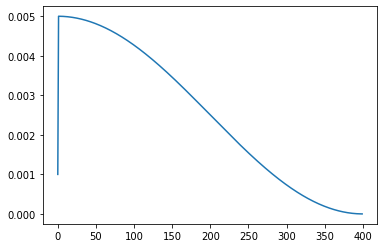

In [25]:
start_lr = 0.005 #*256/batch_size
alpha = 0.0001
decay_steps = epochs

def lr_scheduler(epoch, start_lr):
    if epoch < 1:
      lr = (start_lr-0.001)/1*epoch+0.001
    else:
      cosine_decay = 0.5 * (1 + tf.cos(np.pi * epoch / (decay_steps)))
      decayed = (1 - alpha) * cosine_decay + alpha
      lr = start_lr * decayed
    return lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lr_scheduler(epoch, start_lr), verbose=1)

#Plot learning rate

x_range = np.arange(epochs)
y = [lr_scheduler(x, start_lr) for x in x_range]
plt.plot(x_range, y)
print('Learning rate per epoch:')

Create and compile the model.

In [26]:
network_name = 'EfficientNetLiteB0mod12_GPU_32px_cross_validation'

base_model = EfficientNetLiteB0mod(input_shape=(target_image_size, target_image_size, 150),weights=None)
model = tf.keras.Sequential([base_model,  
                                layers.Flatten(),
                                    layers.Dense(4, kernel_initializer=tf.keras.initializers.GlorotUniform(seed=1509))])

def custom_metric(y_true, y_pred):
    y_true = tf.multiply(y_true, max_gt_values)
    y_pred = tf.multiply(y_pred, max_gt_values)
    mse = tf.reduce_mean((y_true-y_pred)**2, axis=0)
    score = tf.reduce_mean(mse/mse_baseline)

    return score

opt = keras.optimizers.Adam(clipnorm=1.)
model.compile(
    optimizer=opt,
    loss='mse',
    metrics=[custom_metric],
  )

model.summary()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:198: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 150 input channels.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetlite0 (Function  (None, 1, 1, 1280)       728896    
 al)                                                             
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 4)                 5124      
                                                                 
Total params: 734,020
Trainable params: 719,780
Non-trainable params: 14,240
_________________________________________________________________


Define saving paths.

In [27]:
base_path = '/content/'

checkpoint_filepath = base_path + network_name + '/model_test_partition_' + str(test_partition_id) 
predictions_filepath = base_path + network_name + '/predictions_test_partition_' + str(test_partition_id) + '.csv'

print(checkpoint_filepath)
print(predictions_filepath)

/content/EfficientNetLiteB0mod12_GPU_32px_cross_validation/model_test_partition_5
/content/EfficientNetLiteB0mod12_GPU_32px_cross_validation/predictions_test_partition_5.csv


Train the model.

In [ ]:
History = model.fit(train_data, epochs=epochs, callbacks=[lr_callback], validation_data=val_data)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/400
43/43 [==============================] - 11s 132ms/step - loss: 0.4275 - custom_metric: 330.4252 - val_loss: 0.1390 - val_custom_metric: 188.7691 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.004999923054128885.
Epoch 2/400
43/43 [==============================] - 6s 131ms/step - loss: 0.3713 - custom_metric: 313.3016 - val_loss: 0.0726 - val_custom_metric: 39.9877 - lr: 0.0050

Epoch 3: LearningRateScheduler setting learning rate to 0.004999691620469093.
Epoch 3/400
43/43 [==============================] - 5s 120ms/step - loss: 0.0426 - custom_metric: 29.5092 - val_loss: 0.0078 - val_custom_metric: 1.5548 - lr: 0.0050

Epoch 4: LearningRateScheduler setting learning rate to 0.0049993060529232025.
Epoch 4/400
43/43 [==============================] - 5s 119ms/step - loss: 0.0315 - custom_metric: 15.6672 - val_loss: 0.0061 - val_custom_metric: 1.8952 - lr: 0.0050

Epoch 5: LearningRateSc

Export trained model.

In [ ]:
model.save(checkpoint_filepath)

Show some training info.

In [ ]:
min_metric_epoch = tf.math.argmin(History.history['custom_metric'])
min_metric = History.history['custom_metric'][min_metric_epoch]
loss_min_metric = History.history['loss'][min_metric_epoch]
val_metric = History.history['val_custom_metric'][min_metric_epoch]
val_loss = History.history['val_loss'][min_metric_epoch]

print('Best model at epoch', (min_metric_epoch.numpy() + 1))
print('Metric:', min_metric)
print('Loss:', loss_min_metric)
print('Validation metric:', val_metric)
print('Validation loss:', val_loss)

Best model at epoch 387
Metric: 0.6574747562408447
Loss: 0.004387478809803724
Validation metric: 0.5108354091644287
Validation loss: 0.0034926878288388252


Show training progress.

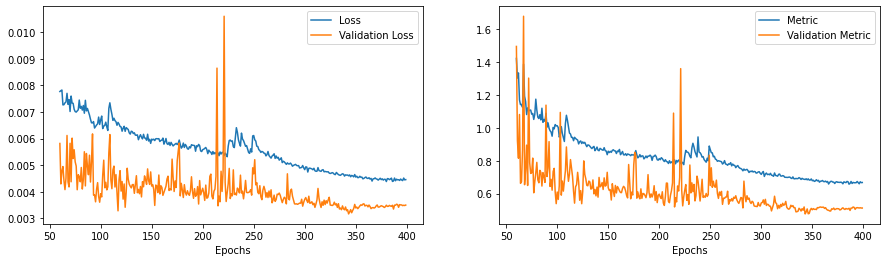

In [ ]:
start_epoch_loss = 60
epochs_interval_loss = range(start_epoch_loss, epochs)
start_epoch_metric = 60
epochs_interval_metric = range(start_epoch_metric, epochs)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))

ax1.plot(epochs_interval_loss, History.history['loss'][start_epoch_loss:], label='Loss')
ax1.plot(epochs_interval_loss, History.history['val_loss'][start_epoch_loss:], label='Validation Loss')
ax1.set_xlabel("Epochs")
ax1.legend(loc='upper right')

ax2.plot(epochs_interval_metric, History.history['custom_metric'][start_epoch_metric:], label='Metric')
ax2.plot(epochs_interval_metric, History.history['val_custom_metric'][start_epoch_metric:], label='Validation Metric')
ax2.set_xlabel("Epochs")
ax2.legend(loc='upper right')

plt.show()

# Load model and make predictions



Define test set preprocessing functions.

In [28]:
def normalize_test(image, label, height, width, std_vec, max_gt_values):             #Function to normalize the test dataset
    image = tf.cast(image,tf.float32)
    image = image/std_vec
    label = label/max_gt_values

    return image, label, height, width

def image_repetition_test(image, height, width):    #Function that repeats small images applying random flips to create a bigger image
    nx = tf.math.floordiv(target_image_size, tf.cast(width, tf.int32))
    ny = tf.math.floordiv(target_image_size, tf.cast(height, tf.int32))
    
    image = tf.tile(image, [ny, nx, 1])
    image = tf.cond(tf.math.maximum(nx, ny)==1, lambda: tf.image.resize(image, [target_image_size, target_image_size], method='bilinear', antialias=False), lambda: tf.image.pad_to_bounding_box(image, 0, 0, target_image_size, target_image_size))

    return image

def pad_with_patches_test(image, label, height, width):    #Function to resize images to [128,128,150]
    max_dim = tf.math.maximum(height, width)
    image = tf.cond(max_dim<target_image_size, lambda: image_repetition_test(image, height, width), lambda: tf.image.resize(image, [target_image_size, target_image_size], method='bilinear', antialias=False))

    return image, label

Preprocessing of test dataset.

In [29]:
test_data = load_tf_records(tf_records_path.format(test_partition_id)).map(decode_dataset, num_parallel_calls=AUTO)

# Normalize, pad, cache, batch and prefetch test set
test_data = test_data.map(lambda image, label, height, width: normalize_test(image, label, height, width, std_vec, max_gt_values), num_parallel_calls=AUTO)
test_data = test_data.map(lambda image, label, height, width: pad_with_patches_test(image, label, height, width), num_parallel_calls=AUTO).cache()
test_data = test_data.batch(batch_size=batch_size, drop_remainder=False).prefetch(AUTO)

Print some entries from the test dataset

[0.16707692 0.2752     0.4375     0.4642857 ]


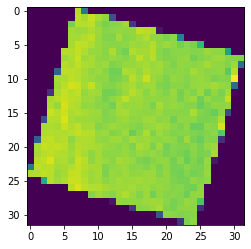

[0.24       0.4768     0.435      0.45714286]


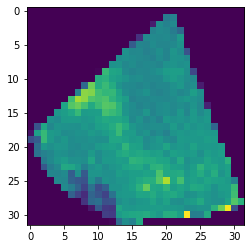

[0.35076922 0.3872     0.385      0.49428573]


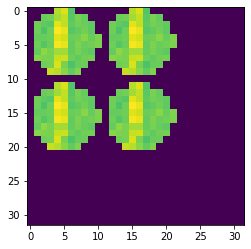

[0.15015385 0.2928     0.3625     0.47857141]


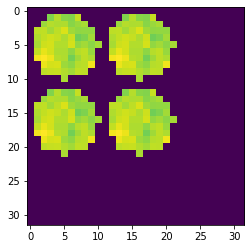

[0.23323078 0.288      0.37       0.4857143 ]


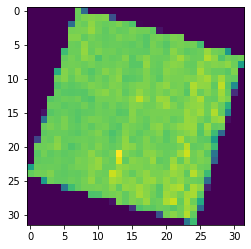

In [30]:
for image, label in test_data.unbatch().take(5):
    plt.imshow(image[:,:,0].numpy())
    print(label.numpy())
    plt.show()
    

Load the exported model.

In [33]:
loaded_model = keras.models.load_model(checkpoint_filepath, custom_objects={'custom_metric': custom_metric})

loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetlite0 (Function  (None, 1, 1, 1280)       728896    
 al)                                                             
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 4)                 5124      
                                                                 
Total params: 734,020
Trainable params: 719,780
Non-trainable params: 14,240
_________________________________________________________________


Make predictions and generate csv file.

In [ ]:
predictions = loaded_model.predict(test_data)

submission = pd.DataFrame(data=predictions, columns=["P", "K", "Mg", "pH"])
submission.to_csv(predictions_filepath, index_label="sample_index")

Evaluate model performace.

In [ ]:
gt = np.array(list(test_data.unbatch().map(lambda image, label: label)))

score = custom_metric(gt, predictions)

print(score.numpy())

0.76751924
